# Кластеризация предобработанных данных

## Цель проекта 
На обезличенных данных выделить сегменты клиентов по их покупательскому поведению. Внутри одного сегмента клиенты должны быть схожи между собой. Клиенты, попавшие в разные сегменты, должны иметь существенные отличия в своих покупках в баре.
Сегментация делается для дальнейшего маркетингового анализа, выделения привлекательных (целевых) сегментов клиентов, разработки адекватного продуктового предложения и позиционирования. 

## Задача проекта
Методом кластеризации разделить клиентов на группы и описать выявленные сценарии покупательского поведения.

## Данные 
Покупки клиентов бара в течение 1 месяца (Дата-фрейм получен в ноутбуке "1Предобработка и разведочный анализ").

## Этапы работы 

1. Оцениваем число кластеров с помощью Метода локтя и Алгоритма DBSCAN. В качестве метрики выбираем Коэф.силуэта, т.к. мы не располагаем размеченными данными. Результат: предварительно рассматриваем версию разбиения на 2-4 кластера.

2. Визуализируем кластеры. Для этого стандартизированные наблюдения размещаем на двумерной плоскости с помощью методов снижения размерности PCA и T-SNE

3. Находим центры кластеризации с помощью KMeans.

    3.1. Для нестандартизированных данных получаем 3 кластера, кластеры отличаются по кол-ву посещений и ARPU. Данное разбиение отражает 3 разных сценария посещения бара.

    3.2. Для стандартизированных данных:  неудовлетворительный максимальный коэф.силуэта (0.407) и размытая интерпретация данных.

    3.3. Для нормализованных данных: несмотря на неубедительные коэф.силуэта, кластеризация происходит с жёсткой разбивкой по полу (м/ж), что представляет интерес. Получаем 4 кластера, отличающихся по полу (м/ж) и дню недели посещения (сб - для мужчин, пт - для девушек).

4. Дополнительные расчеты: 

    4.1. Агломеративная кластеризация
    
    4.2. Иерархическая кластеризация, 
    
    4.3. Проверка на данных, которые не содержат аномалий, выявленных алгоритмом DBSCAN.

    Подтверждается разбивка на 2-4 кластера.


## Выводы:

### 3 кластера отражают 3 разных сценария посещения бара (получены методом K-Means) в зависимости от количества посещений в месяц, состава компаниии, что отражается на доходности клиентов (ARPU)

### 4 кластера образовались при жёстком разбиении по полу и дню недели посещения (сб - для мужчин, пт - для девушек). Получены методом K-Means для нормализованных данных.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import cycle, islice

In [2]:
warnings.simplefilter('ignore')

In [3]:
#Будем работать с тремя вариантами входных данных: исходных X, стандартизированных X1 и нормализованных X2:

def load(file, num):
    X = pd.read_excel(file)

    scaler1 = StandardScaler()
    X1 = scaler1.fit_transform(X)

    scaler2 = MinMaxScaler()
    X2 = scaler2.fit_transform(X)
    
    if num == 0:
        return X
    elif num == 1:
        return X1
    elif num == 2:
        return X2

In [4]:
X=load('Data_Sept2019.xlsx', 0)
X.shape

(15577, 35)

In [5]:
X1=load('Data_Sept2019.xlsx', 1)
X2=load('Data_Sept2019.xlsx', 2)

## 1. Оцениваем число кластеров с помощью Метода локтя и Алгоритма DBSCAN

In [6]:
# Функция для визуализации результата кластеризации по методу локтя

def elbow(X):
    sse = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
        X["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    return plt.show()

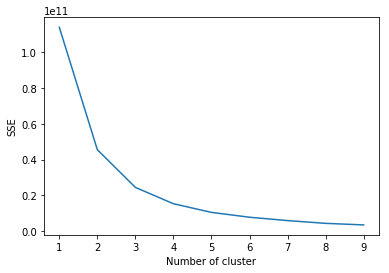

In [7]:
elbow(X)

1. МЕТОД ЛОКТЯ показывает, что после 4-х кластеров дальнейшая сегментация не даёт существенного уменьшения SSE (суммы квадратов ошибок до центра кластера).


2. Для DBSCAN создаём список с вариантами параметра eps и перебираем этот параметр в цикле.
    Смотрим, в каком случае коэффициент силуэта максимальный с приемлемым количеством выбросов.

    Используем X2 = MinMaxScaler().fit_transform(X)

    При eps=0.7 алгоритм DBSCAN выдаёт 2 примерно одинаковых кластера (коэф.силуэта = 0.589, выбросов 100 наблюдений из 15577).

    В качестве метрики выбираем Коэф.силуэта, т.к. мы не располагаем размеченными данными

### Итак, предварительно рассматриваем версию разбиения на 2-4 кластера. 

In [8]:
param = []
for x in range(1,10):
    param.append(x/10)
    param.append(round(x/10+0.05,2))
print(param)

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [9]:
# Функция для расчета коэф.силуэта при использовании DBSCAN

def dbscan_sil(low, high):

    for j in param[low:high]:
    
        dbscan = DBSCAN(eps=j, min_samples=100)
        dbscan.fit(X2)
        y_pred = dbscan.labels_.astype(np.int)
        s = silhouette_score(X=X2, labels=y_pred, metric='euclidean')
        print('eps ', j, s)
    
        counts = np.unique(y_pred, return_counts=True)
        for count in counts: 
            print(count, end='\n')
        
        df10 = pd.read_excel('Data_Sept2019.xlsx')
        
        feature_names = df10.columns.tolist()
        for element in feature_names:
            if element == 'Кластер DBSCAN':
                df10 = df10.drop(element, axis='columns')
              
        df10['Кластер DBSCAN'] = df10.apply(lambda x: 0) 

        for number, i in enumerate(y_pred):
            df10.loc[[number],'Кластер DBSCAN']=i
            
        with pd.ExcelWriter(str(int(j*10))+'.xlsx') as writer:  # doctest: +SKIP
            df10.to_excel(writer, sheet_name='data', index=False)

In [10]:
dbscan_sil(11,13)

eps  0.65 0.5889171856978155
[-1  0  1]
[ 134 7935 7508]
eps  0.7 0.5891135536681112
[-1  0  1]
[ 100 7956 7521]


## 2. Визуализируем кластеры

Для этого стандартизированные наблюдения размещаем на двумерной плоскости с помощью методов снижения размерности PCA, T-SNE

In [11]:
pca = PCA(n_components = 2)
dec = pca.fit_transform(X1)
dec.shape

(15577, 2)

In [12]:
X_embedded = TSNE(n_components=2).fit_transform(X1)
X_embedded.shape

(15577, 2)

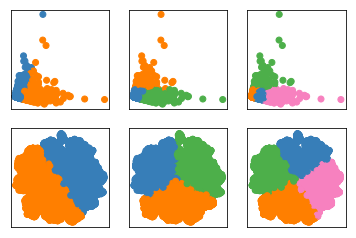

In [13]:
# создаём массив пар – датасета и соответствующих для него параметров алгоритма
datasets_params_list = [
    (dec, {'n_clusters': 2}),
    (dec, {'n_clusters': 3}),
    (dec, {'n_clusters': 4}),
    (X_embedded, {'n_clusters': 2}),
    (X_embedded, {'n_clusters': 3}),
    (X_embedded, {'n_clusters': 4})]

for i, (X, k_means_params) in enumerate(datasets_params_list, start=1):
    X = StandardScaler().fit_transform(X)
    k_means = KMeans(n_clusters=k_means_params['n_clusters'])
    
    k_means.fit(X)
    y_pred = k_means.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])

1. Метод главных компонент PCA в сочетании с K-Means выдает разные по объему кластеры
2. Метод T-SNE в сочетании с алгоритмом K-Means разбивает наблюдения примерно на равные по объему кластеры

In [14]:
#break

## 3. Для получения центров кластеризации используем KMeans

Определим количество кластеров перебором значений от 2 до 8. Вычисляем коэф.силуэта.

Определяем центры получившихся кластеров.

In [15]:
# Функция для подсчета коэф.силуэта при использовании KMeans

def siluet(file, num, low, high):
    X = load(file, num)
    for i in range(low, high):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        kmeans_pred = kmeans.labels_
        s=silhouette_score(X=X, labels=kmeans_pred, metric='euclidean')
        print('число кластеров ', i, s)    

In [16]:
# Функция для кластеризации и нахождения центров кластеров

def k_center(file, num):
    
    for i in range(2,5):
        
        df10 = pd.read_excel(file)
        
        if num == 0:
            X = df10
            
        elif num == 1:
            scaler1 = StandardScaler()
            X = scaler1.fit_transform(df10)
            
        elif num == 2:
            scaler2 = MinMaxScaler()
            X = scaler2.fit_transform(df10)
    
        kmeans = KMeans(n_clusters=i, random_state=42)
        # Для обучения модели K-means необходимо вызвать метод fit, передав входным параметром признаки объектов датасета:
        kmeans.fit(X)
        
        # Обучив, мы можем получить центроиды кластеров:
        if num == 0:
            a = kmeans.cluster_centers_
        elif num == 1:
            a1 = kmeans.cluster_centers_
            a = scaler1.inverse_transform(a1)    
        elif num == 2:
            a1 = kmeans.cluster_centers_
            a = scaler2.inverse_transform(a1)

        # Определяем, в какой кластер попал каждый из объектов:
        b = kmeans.labels_

        # Для подсчёта элементов в списке можно воспользоваться функцией numpy.unique с параметром return_counts=True:

        counts = np.unique(b, return_counts=True)
        for count in counts:
            print(count, end=' ')
    
        feature_names = df10.columns.tolist()
        for element in feature_names:
            if element == 'Кластер K-means':
                df10 = df10.drop(element, axis='columns')

        feature_names = df10.columns
        featureImportance = pd.DataFrame(np.round(a, 2)) 
        featureImportance.columns = feature_names

        df10['Кластер K-means'] = df10.apply(lambda x: 0) 

        for number, i in enumerate(b):
            df10.loc[[number],'Кластер K-means']=i

        for number, i in enumerate(count):
            featureImportance.loc[[number],'К-во']=i
    
        list = []
        list.append(featureImportance.columns[-1])
        for i in feature_names:
            list.append(i)
    
        featureImportance = featureImportance[list].T
        print(featureImportance)
        print('\n')

###  3.1. Для нестандартизированных данных X:
* При 2-х кластерах коэф.силуэта максимальный (0.715)
* При 3-х 0.648
* При 4-х 0.611

In [17]:
siluet('Data_Sept2019.xlsx', 0, 2, 9)

число кластеров  2 0.7149871007837191
число кластеров  3 0.6478108014210783
число кластеров  4 0.6109499834651366
число кластеров  5 0.5833910629547112
число кластеров  6 0.5691504600982025
число кластеров  7 0.5636092762716508
число кластеров  8 0.5548888881617569


In [18]:
k_center('Data_Sept2019.xlsx', 0)

[0 1] [13476  2101]                             0        1
К-во                 13476.00  2101.00
Пол                      0.50     0.58
ARPU                  1895.43  8026.80
Посещений                1.25     2.57
Коктейли для друзей      0.41     2.37
Акции                    0.40     1.99
Лонги                    1.01     3.71
Пиво для друзей          0.46     1.77
Пиво до 1л               1.83     5.09
Сеты                     1.19     6.29
Наборы на компанию       0.46     1.58
Горячие блюда            0.41     1.47
Горячие напитки          0.06     0.20
Кальяны                  0.19     0.76
Снэки                    0.46     1.31
Соусы, хлеб              0.18     0.61
Холодные напитки         0.28     1.39
Крепкий алкоголь         0.45     3.01
Роллы                    0.23     0.79
Пицца                    0.13     0.44
Супы                     0.03     0.09
Стритфуд                 0.17     0.62
Десерты                  0.05     0.16
Салаты                   0.10     0.32
Вино 

### Итак, методом K-Means для нестандартизированных данных X получаем 2, 3, 4 кластера. Кластеры отличаются по кол-ву посещений и ARPU

#### При разбиении на 2 кластера средние цифры выглядят так:

* 1-й кластер (13476 клиентов): Посещений 1,25 раз в месяц и ARPU 1895 руб. Пол: поровну мужчин и девушек.

* 2-й кластер (2101 клиент): Посещений 2,57 раз в месяц и ARPU 8027 руб. Пол: чаще мужчины, чем девушки. 
Во 2-м кластере посещений на 1 человека в 2 раза больше, при этом непропорционально больше заказывается "Коктейлей для друзей"
(куда входят 3 порции), Лонгов (=коктейлей), Пива для друзей (3 порции в наборе), Крепкий алкоголь и холодные напитки 
(к нему же), Сетов. 
Это более компанейский вариант посещения.


#### При разбиении на 3 кластера средние цифры выглядят так:

Основная масса клиентов попала в кластер 1. Сосредоточим своё внимание на более высокодоходных клиентах из кластеров 2 и 3.
Средние цифры выглядят так:

* 1-й кластер (11416 клиентов): Посещений 1,18 раз в месяц и ARPU 1513 руб. Пол: поровну мужчин и девушек.

* 2-й кластер (3595 клиентов): Посещений 1,88 раз в месяц и ARPU 5034 руб. Пол: почти поровну мужчин и девушек.

* 3-й кластер (566 клиентов) самый высокодоходный: Посещений 3,65 раз в месяц и ARPU 12442 руб. Пол: чаще мужчины, чем девушки. 
В 3-м кластере посещений на 1 человека в 2 раза больше, чем во 2-м, при этом непропорционально больше заказывается Сетов (алкогольных), Крепкого алкоголя и Холодных напитков к ним. А также напитков TO GO и Бизнес-Ланчей. 
Это наиболее компанейский вариант посещения, который возможен даже в дневное время (на что указывают Бизнес-Ланчи).


### В целом, данное разбиение нестандартизированных данных на 3 кластера видится обоснованным - оно отражает 3 разных сценария посещения бара.


#### Разбиение на 4 кластера приведено справочно.



###  3.2. Теперь сделаем кластеризацию стандартизированных данных X1

Число кластеров при переборе ограничим от 2-х до 4.

In [19]:
siluet('Data_Sept2019.xlsx', 1, 2, 5)

число кластеров  2 0.40721685542343145
число кластеров  3 0.23317571850059932
число кластеров  4 0.23197502833100855


* Метод K-Means для стандартизированных данных X1 выдал 2 кластера с максимальным коэф.силуэта 0.407. Нас это не устраивает.

### 3.3. Применим K-Means для нормализованных данных X2:

несмотря на неубедительные коэф.силуэта, кластеризация происходит с жёсткой разбивкой по полу (м/ж), что представляет интерес.


In [20]:
siluet('Data_Sept2019.xlsx', 2, 2, 5)

число кластеров  2 0.587493787054266
число кластеров  3 0.38627161092323015
число кластеров  4 0.19016205939366282


In [21]:
k_center('Data_Sept2019.xlsx', 2)

[0 1] [7561 8016]                            0        1
К-во                 7561.00  8016.00
Пол                     0.00     1.00
ARPU                 2567.72  2868.34
Посещений               1.39     1.48
Коктейли для друзей     0.74     0.61
Акции                   0.57     0.66
Лонги                   1.65     1.11
Пиво для друзей         0.45     0.81
Пиво до 1л              1.96     2.56
Сеты                    1.69     2.05
Наборы на компанию      0.57     0.66
Горячие блюда           0.56     0.55
Горячие напитки         0.08     0.09
Кальяны                 0.28     0.26
Снэки                   0.58     0.58
Соусы, хлеб             0.24     0.23
Холодные напитки        0.39     0.47
Крепкий алкоголь        0.58     0.99
Роллы                   0.39     0.23
Пицца                   0.18     0.16
Супы                    0.04     0.04
Стритфуд                0.21     0.25
Десерты                 0.08     0.04
Салаты                  0.15     0.10
Вино 125 мл             0.12    

## Итак, методом K-Means для нормализованных данных X2 рассмотрим 4 кластера, отличающихся по полу (м/ж) и дню недели для посещения (сб - для мужчин, пт - для девушек).

Средние цифры выглядят так:

* Для мужчин (кластеры номер 2 и 4):

Количество клиентов соответственно 5836 и 2180. За 1 месяц они в среднем тратят соответственно 2497 руб. за 1,33 посещений или же 3863 руб. за 1,85 посещений. Клиенты с более высокими расходами непропорционально больше заказывают "Коктейли для друзей" (3 порции в одном наборе), Кальянов; меньше подпадают под Акции и меньше заказывают Бизнес-Ланчей. Это сценарий посещения в прайм-тайм в календарную субботу (это может быть также ночное время пт/сб и сб/вс).

* Рассмотрим кластеры, которые сформированы девушками (номер 1 и 3):

Количество клиентов соответственно 1546 и 6015. 
За 1 месяц они в среднем тратят соответственно 3286 руб. за 1,76 посещений или же 2383 руб. за 1,29 посещений.
Клиенты с более высокими расходами непропорционально больше заказывают "Пиво для друзей" (3 порции в одном наборе), Крепкий алкоголь, Супы, Вино (в бутылках), Напитки TO GO (с собой), Бизнес-Ланч; меньше подпадают под Акции. Это сценарий посещения в прайм-тайм в календарную пятницу.

* Если дополнительно рассмотреть разбиение на только 2 кластера (также жёсткое по полу м/ж), то можно видеть, что  у девушек выше спрос на вино, лонги (коктейли), роллы, салаты и десерты по сравнению с мужчинами, и меньше интерес к крепкому алкоголю и "пиву для друзей". 

## В целом, данное разбиение нормализованных данных на 4 кластера видится обоснованным


In [22]:
#break

# 4. Дополнительные методы


## 4.1. Результаты Агломеративной кластеризации

Максимальные коэф.силуэта без матрицы смежности / с матрицей смежности соответствуют разбиению на 2 кластера.

In [23]:
X = load('Data_Sept2019.xlsx', 0)
X1 = load('Data_Sept2019.xlsx', 1)
X2 = load('Data_Sept2019.xlsx', 2)

In [24]:
list = [X,X1,X2]

In [25]:
#Функция для агломеративной кластеризации

def aglomerativnaya(list):
    
    for number, j in enumerate(list):
        if number == 0:
            print('Для массива X')
        elif number == 1:
            print('Для массива X1')
        else:
            print('Для массива X2')
            
    
        for i in range(2,5):
            ac1 = AgglomerativeClustering(n_clusters=i,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )
            with warnings.catch_warnings():
                warnings.filterwarnings(
                "ignore",
                    message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                ac1.fit(j)
            y_pred1 = ac1.labels_.astype(np.int)
            s = silhouette_score(X=j, labels=y_pred1, metric='euclidean')
            print('число кластеров ', i, s)
            
    
        # строим матрицу смежности
        # делаем матрицу смежности симметричной

        connectivity = kneighbors_graph(X, n_neighbors=6, include_self=False)
        connectivity = 0.5 * (connectivity + connectivity.T)

        for i in range(2,5):
            ac1 = AgglomerativeClustering(n_clusters=i,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', connectivity=connectivity 
                            )
            with warnings.catch_warnings():
                warnings.filterwarnings(
                "ignore",
                    message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                ac1.fit(j)
            y_pred1 = ac1.labels_.astype(np.int)
            s = silhouette_score(X=j, labels=y_pred1, metric='euclidean')
            print('число кластеров с матрицей смежности ', i, s)
            
        print('\n')

In [26]:
aglomerativnaya(list)

Для массива X
число кластеров  2 0.734307884682819
число кластеров  3 0.6005100182126274
число кластеров  4 0.6101046799983515
число кластеров с матрицей смежности  2 0.734307884682819
число кластеров с матрицей смежности  3 0.5138113171394809
число кластеров с матрицей смежности  4 0.5180033383507094


Для массива X1
число кластеров  2 0.2398044034961192
число кластеров  3 0.2384739539399902
число кластеров  4 0.2325392846541106
число кластеров с матрицей смежности  2 0.2139974898200351
число кластеров с матрицей смежности  3 0.1711424860519278
число кластеров с матрицей смежности  4 0.17147325880243347


Для массива X2
число кластеров  2 0.5874251001605955
число кластеров  3 0.3859901515001363
число кластеров  4 0.19505963438722143
число кластеров с матрицей смежности  2 0.012857824587067329
число кластеров с матрицей смежности  3 -0.08266696011438669
число кластеров с матрицей смежности  4 -0.10341466843314243




## 4.2. Иерархическая кластеризация 


* Для нестандартизированных данных X получили 2-4 кластера.

In [27]:
X=load('Data_Sept2019.xlsx', 0)

In [28]:
# Функция для построения дендрограммы для иерархической кластеризации

def tree(X):
    
    mergings = linkage(X.sort_values(by=['ARPU', 'Посещений', 'Пол']).values, method='complete')
    dendrogram(mergings, leaf_font_size=100, no_labels=True)
    
    return plt.show()

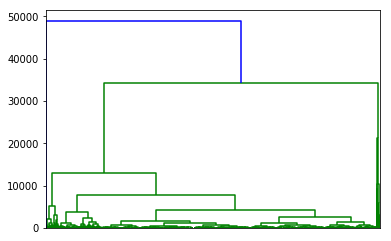

In [29]:
tree(X)

In [30]:
#break

## 4.3. Проверка на данных, которые не содержат аномалий 


Алгоритм DBSCAN при максимальном коэф.силуэта определил в качестве выбросов 100 наблюдений из 15577.


Обратимся к размеченному файлу, очистим его от наблюдений с номером кластера "-1" и повторим кластеризацию.


### При разведочном анализе других существенных отличий от первоначальных данных не выявлено, кроме распределения ARPU и кол-ва посещений.

* Размах ARPU от 58 руб. до 21733 руб. (прежде было 49016 руб.) с медианным значением 1872 руб. (прежде 1889 руб). Максимальное кол-во посещений стало 10 (было 28).


### Кластеризация интерпретируется практически так же, как и на полных данных. 

* Коэффициенты силуэта несколько ниже. 

* Исключение составляет разбиение на 4 кластера нормализованных данных (по полу м/ж, ARPU, дню недели): более высокодоходные клиенты (и мужчины, и девушки) в среднем в 3 раза чаще бывают в баре в пятницу, чем менее доходные клиенты. Влияние субботы на данной выборке менее выявлено. 


In [31]:
Modif=load('7.xlsx', 0)
Modif.shape

(15577, 36)

In [32]:
Modif=Modif[Modif['Кластер DBSCAN']>=0]
X=Modif.drop('Кластер DBSCAN', axis='columns')
X.shape

(15477, 35)

In [33]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Пол,15477.0,0.514053,0.499819,0.0,0.0,1.0,1.0,1.0
ARPU,15477.0,2634.954175,2411.789151,58.0,1046.0,1872.0,3392.0,21733.0
Посещений,15477.0,1.390580,0.826823,1.0,1.0,1.0,2.0,10.0
Коктейли для друзей,15477.0,0.647671,1.491852,0.0,0.0,0.0,1.0,20.0
Акции,15477.0,0.591329,1.454624,0.0,0.0,0.0,0.0,26.0
Лонги,15477.0,1.340764,2.404748,0.0,0.0,0.0,2.0,28.0
Пиво для друзей,15477.0,0.612522,1.271171,0.0,0.0,0.0,1.0,21.0
Пиво до 1л,15477.0,2.179234,3.307483,0.0,0.0,1.0,3.0,44.0
Сеты,15477.0,1.829101,3.368999,0.0,0.0,0.0,2.0,47.0
Наборы на компанию,15477.0,0.604898,0.893493,0.0,0.0,0.0,1.0,9.0


Text(0.5, 0, 'ARPU, руб.')

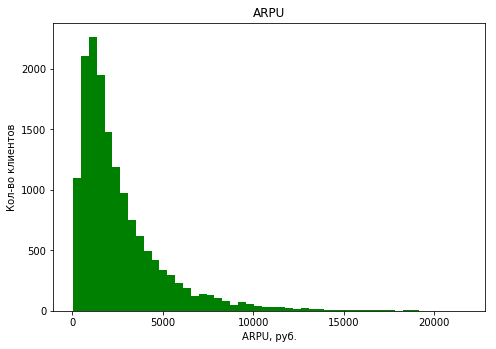

In [34]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(X['ARPU'], bins=50, color = 'green')
axes.set_title('ARPU')
axes.set_ylabel('Кол-во клиентов')
axes.set_xlabel('ARPU, руб.')

In [35]:
spisok = ['Пол', 'Посещений']
for i in spisok:
    print(X[i].value_counts())
    print('\n')

1    7956
0    7521
Name: Пол, dtype: int64


1     11489
2      2737
3       788
4       274
5        95
6        54
7        27
8         7
9         5
10        1
Name: Посещений, dtype: int64




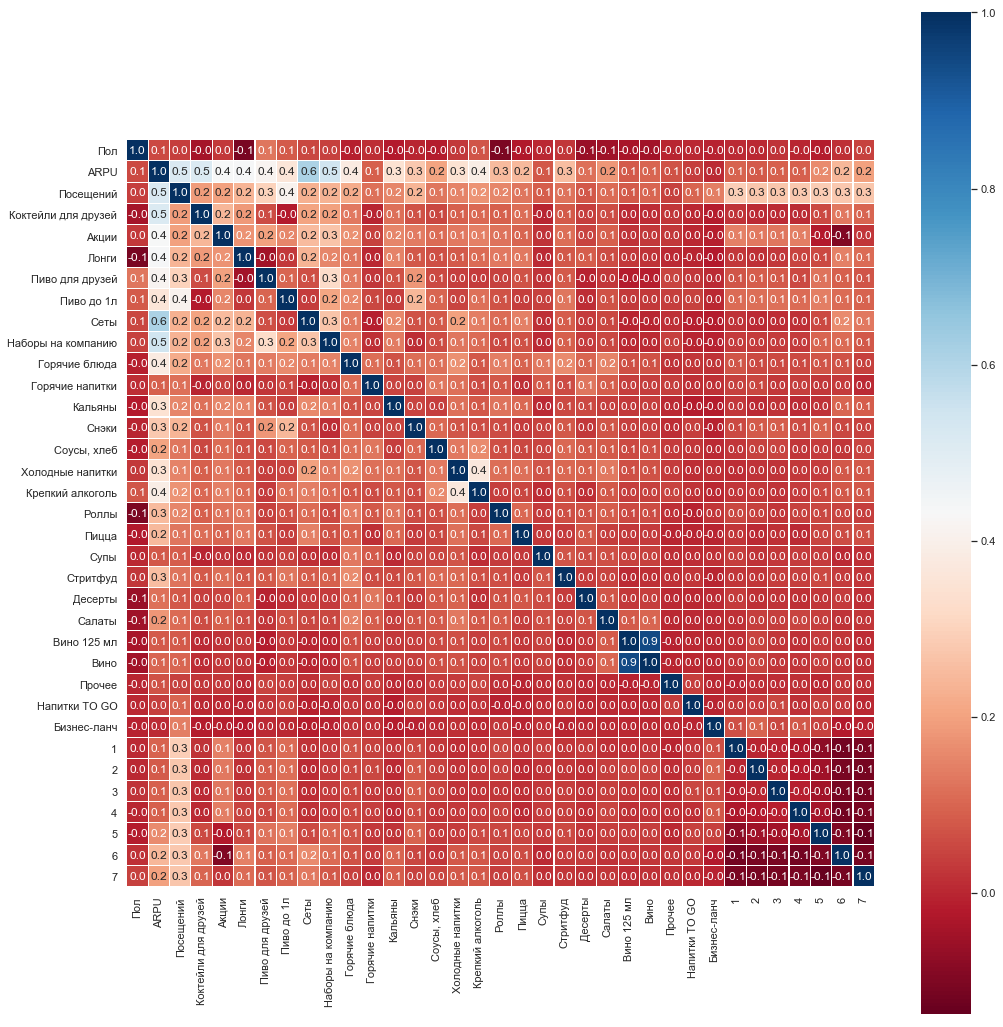

In [36]:
sns.set(font_scale=1)
plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()
plt.savefig('car_corr_clear.png')

In [37]:
with pd.ExcelWriter('Clear.xlsx') as writer:  # doctest: +SKIP
    X.to_excel(writer, sheet_name='data', index=False)

In [38]:
X=load('Clear.xlsx', 0)
X.shape

(15477, 35)

In [39]:
X1=load('Clear.xlsx', 1)
X2=load('Clear.xlsx', 2)

In [40]:
#elbow(X)

In [41]:
pca = PCA(n_components = 2)
dec = pca.fit_transform(X1)
dec.shape

(15477, 2)

In [42]:
X_embedded = TSNE(n_components=2).fit_transform(X1)
X_embedded.shape

(15477, 2)

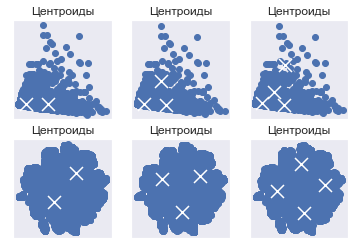

In [64]:
# создаём массив пар – датасета и соответствующих для него параметров алгоритма
datasets_params_list = [
    (dec, {'n_clusters': 2}),
    (dec, {'n_clusters': 3}),
    (dec, {'n_clusters': 4}),
    (X_embedded, {'n_clusters': 2}),
    (X_embedded, {'n_clusters': 3}),
    (X_embedded, {'n_clusters': 4})]

for i, (X, k_means_params) in enumerate(datasets_params_list, start=1):
    X = StandardScaler().fit_transform(X)
    k_means = KMeans(n_clusters=k_means_params['n_clusters'])
    
    k_means.fit(X)
    y_pred = k_means.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
        
    centroids = k_means.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title('Центроиды')
   
    plt.scatter(X[:, 0], X[:, 1])

In [65]:
siluet('Clear.xlsx', 0, 2, 9)

число кластеров  2 0.6957405444260627
число кластеров  3 0.6276822984761389
число кластеров  4 0.5930609991684059
число кластеров  5 0.5760824350726772
число кластеров  6 0.5540581062834637
число кластеров  7 0.5525620866709231
число кластеров  8 0.5432495639107989


In [66]:
k_center('Clear.xlsx', 0)

[0 1] [12917  2560]                             0        1
К-во                 12917.00  2560.00
Пол                      0.50     0.57
ARPU                  1775.42  6965.82
Посещений                1.23     2.20
Коктейли для друзей      0.37     2.06
Акции                    0.37     1.70
Лонги                    0.95     3.30
Пиво для друзей          0.43     1.51
Пиво до 1л               1.77     4.26
Сеты                     1.08     5.59
Наборы на компанию       0.44     1.45
Горячие блюда            0.39     1.28
Горячие напитки          0.06     0.15
Кальяны                  0.18     0.67
Снэки                    0.45     1.11
Соусы, хлеб              0.17     0.51
Холодные напитки         0.27     1.14
Крепкий алкоголь         0.41     2.47
Роллы                    0.22     0.68
Пицца                    0.13     0.39
Супы                     0.03     0.07
Стритфуд                 0.16     0.52
Десерты                  0.04     0.14
Салаты                   0.09     0.26
Вино 

In [67]:
siluet('Clear.xlsx', 1, 2, 5)

число кластеров  2 0.3397404127873205
число кластеров  3 0.3340136108335515
число кластеров  4 0.0319849648201493


In [68]:
siluet('Clear.xlsx', 2, 2, 5)

число кластеров  2 0.47721724429567725
число кластеров  3 0.39298781660445986
число кластеров  4 0.3114070867392853


In [69]:
k_center('Clear.xlsx', 2)

[0 1] [7956 7521]                            0        1
К-во                 7956.00  7521.00
Пол                     1.00     0.00
ARPU                 2763.40  2499.08
Посещений               1.42     1.36
Коктейли для друзей     0.59     0.71
Акции                   0.63     0.55
Лонги                   1.08     1.61
Пиво для друзей         0.77     0.45
Пиво до 1л              2.44     1.90
Сеты                    2.00     1.65
Наборы на компанию      0.64     0.56
Горячие блюда           0.53     0.55
Горячие напитки         0.08     0.07
Кальяны                 0.25     0.27
Снэки                   0.56     0.56
Соусы, хлеб             0.21     0.24
Холодные напитки        0.44     0.38
Крепкий алкоголь        0.93     0.56
Роллы                   0.21     0.39
Пицца                   0.16     0.18
Супы                    0.04     0.04
Стритфуд                0.24     0.21
Десерты                 0.04     0.08
Салаты                  0.10     0.14
Вино 125 мл             0.07    

In [70]:
X = load('Clear.xlsx', 0)
X1 = load('Clear.xlsx', 1)
X2 = load('Clear.xlsx', 2)

In [71]:
list = [X,X1,X2]

In [72]:
aglomerativnaya(list)

Для массива X
число кластеров  2 0.7325535210584565
число кластеров  3 0.613704932986499
число кластеров  4 0.5402062365330322
число кластеров с матрицей смежности  2 0.6078839963634519
число кластеров с матрицей смежности  3 0.6274847283897601
число кластеров с матрицей смежности  4 0.6250581930063753


Для массива X1
число кластеров  2 0.34277234657523603
число кластеров  3 0.2965223825029932
число кластеров  4 0.301481991462398
число кластеров с матрицей смежности  2 0.29648871935086474
число кластеров с матрицей смежности  3 0.23040056427622
число кластеров с матрицей смежности  4 -0.006138807216194429


Для массива X2
число кластеров  2 0.47721724429567725
число кластеров  3 0.2934986133441561
число кластеров  4 0.15430317366635957
число кластеров с матрицей смежности  2 -0.00020460554251172495
число кластеров с матрицей смежности  3 -0.1455381528884869
число кластеров с матрицей смежности  4 -0.14131317102649094




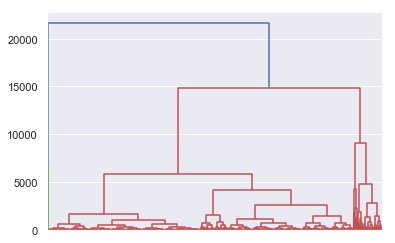

In [73]:
tree(X)

### Проверочные методы подтверждают разбиение на 2-4 основных кластера:

* разбивка на 2 кластера по ARPU (метод K-Means для нестандартизированных данных)


* разбивка на 3 кластера (3 разных сценарии посещения бара клиентами: редкое посещение (1,18 раз) с ARPU 1513 руб; более частое посещение (1,88 раз) с ARPU 5034 руб; частое посещение большой компанией - 3,65 раз с ARPU 12442 руб в месяц). Использовался метод K-Means для нестандартизированных данных.


* Вместо 2-х кластеров считаем целесообразным использовать разбивку на 4 кластера, которыая учитывает пол клиентов (м/ж) и день недели посещения (сб - для мужчин, пт - для девушек). Кластеры получены методом K-Means для нормализованных данных.